# Multi-Armed Bandit with Gymnasium Environment Registration and Observation Wrapper Example

In [2]:
# Importing necessary libraries
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium import ObservationWrapper
import matplotlib.pyplot as plt

## Creating the Multi-Armed Bandit Environment

In [12]:
class MultiArmedBanditEnv(gym.Env):
    def __init__(self, num_arms=5):
        super(MultiArmedBanditEnv, self).__init__()
        self.num_arms = num_arms
        self.action_space = spaces.Discrete(num_arms)
        self.observation_space = spaces.Discrete(1)
        self.probabilities = np.random.rand(num_arms)
        self.state = 0
        
    def step(self, action):
        assert self.action_space.contains(action), f"Invalid action {action}"
        reward = 1 if np.random.rand() < self.probabilities[action] else 0
        done = True  # Each step is terminal in a multi-armed bandit
        return self.state, reward, done, False, {}
    
    def reset(self, seed=None, options=None):
        # Seed the RNG if a seed is provided
        if seed is not None:
            np.random.seed(seed)
        
        self.state = 0
        return self.state, {}
    
    def render(self, mode="human"):
        pass

## Register the environment with gymnasium

In [13]:
register(
    id='MultiArmedBandit-v0',
    entry_point=MultiArmedBanditEnv,
    max_episode_steps=1,
)

## Simulating the Bandit Problem

In [15]:
def simulate(env, num_pulls, strategy='random'):
    env.reset()
    rewards = np.zeros(num_pulls)
    for i in range(num_pulls):
        if strategy == 'random':
            action = env.action_space.sample()
        elif strategy == 'greedy':
            if i > 0:
                q_values = rewards.cumsum()[:i] / np.maximum(1, np.arange(1, i + 1))
                action = np.argmax(q_values)
            else:
                action = env.action_space.sample()
        
        _, reward, _, _, _ = env.step(action)
        rewards[i] = reward
    return rewards

# Check optimal arm probabilities
env = gym.make('MultiArmedBandit-v0', num_arms=5)
optimal_arm = np.argmax(env.probabilities) + 1
print(f"Optimal arm: {optimal_arm} with probabilities {env.probabilities}")

# Simulate
num_pulls = 1000
rewards_random = simulate(env, num_pulls, strategy='random')
rewards_greedy = simulate(env, num_pulls, strategy='greedy')

Optimal arm: 4 with probabilities [0.15514167 0.1005655  0.59769084 0.60831955 0.68806374]


## Visualization

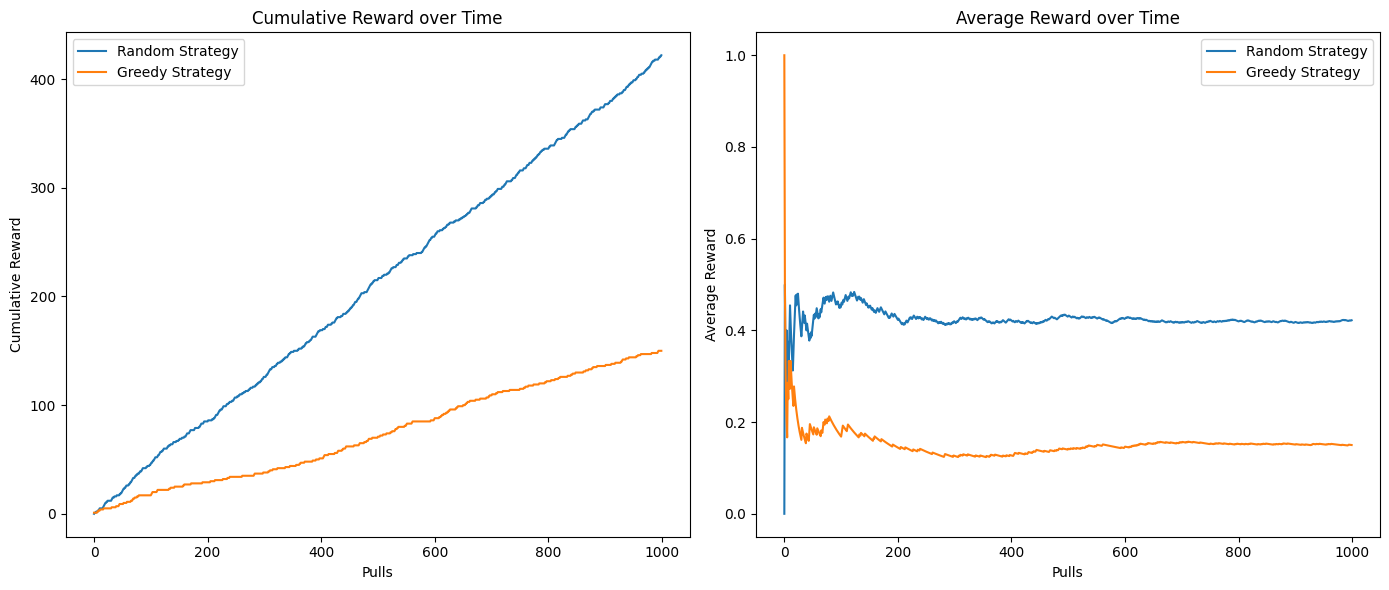

In [16]:
plt.figure(figsize=(14, 6))

# Plot cumulative rewards
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(rewards_random), label='Random Strategy')
plt.plot(np.cumsum(rewards_greedy), label='Greedy Strategy')
plt.xlabel('Pulls')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time')
plt.legend()

# Plot average reward
plt.subplot(1, 2, 2)
plt.plot(np.cumsum(rewards_random) / np.arange(1, num_pulls + 1), label='Random Strategy')
plt.plot(np.cumsum(rewards_greedy) / np.arange(1, num_pulls + 1), label='Greedy Strategy')
plt.xlabel('Pulls')
plt.ylabel('Average Reward')
plt.title('Average Reward over Time')
plt.legend()

plt.tight_layout()
plt.show()

## Example with Observation Wrapper

This saample shows how to add a random value to an observation of an existing environment.

In [22]:
class AugmentObservationWrapper(ObservationWrapper):
    def __init__(self, env):
        super(AugmentObservationWrapper, self).__init__(env)
        # Modify the observation space if necessary
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(2,), dtype=np.float32)

    def observation(self, obs):
        # Example: Augment the observation with a random value
        random_value = np.random.rand()
        return np.array([obs, random_value])

# 6. Simulating with Observation Wrapper
def simulate_with_wrapper(env, num_pulls, strategy='random'):
    rewards = np.zeros(num_pulls)
    for i in range(num_pulls):
        if strategy == 'random':
            action = env.action_space.sample()
        elif strategy == 'greedy':
            if i > 0:
                q_values = rewards.cumsum()[:i] / np.maximum(1, np.arange(1, i + 1))
                action = np.argmax(q_values)
            else:
                action = env.action_space.sample()
        
        obs, reward, _, _, _ = env.step(action)
        print(f"Observation after step {i+1}: {obs}")
        rewards[i] = reward
    return rewards

# Wrap the environment and simulate
wrapped_env = AugmentObservationWrapper(env)
reward = simulate_with_wrapper(wrapped_env, 10)

Observation after step 1: [0.         0.82124521]
Observation after step 2: [0.         0.57966145]
Observation after step 3: [0.         0.01811282]
Observation after step 4: [0.        0.4207884]
Observation after step 5: [0.         0.67940777]
Observation after step 6: [0.        0.9631762]
Observation after step 7: [0.         0.61985737]
Observation after step 8: [0.         0.94582587]
Observation after step 9: [0.         0.28971862]
Observation after step 10: [0.         0.19417661]
